<span style="font-size:12px;">

## BEAM

- 전통적인 RNN 계열은 왼쪽에서 오른쪽으로 가는 방향으로 학습하다보니, 멀리 떨어진 단어들은 서로 영향을 주고 받기 어려움
- The cat that the boy who lived here adopted is sleeping -> cat과 sleeping 연관관계가 있는데 멀리 떨어져있음
- RNN은 순차처리
<br>

- self-attention 병렬처리
- self-attention : 상기와 같이 (cat, sleeping) 떨어진 단어를 서로 바라보면서 예측?
- Q: 찾고 싶은 정보
- K: 가진 정보
- V: 최종 전달할 정보

<br>

- The cat that the boy who lived here adopted is sleeping

|비교대상| 유사도| 낮음|
|--------|-------|-----|
|cat vs the | 낮음 | the 의미없음
|cat vs cat | 높음 | 자기자신
|cat vs sat | 중간 | 동사와 연결
|cat vs on | 낮음 | on 전치사
|cat vs mat | 낮음 | 의미적으로 멀다

<br>

- softmax로 중요 확률처럼 변경 --> 유사도를 가중치로 변환

|단어| 가중치|
|---|--------|
|the|0.05|
|cat|0.6|
|sat|0.3|
|mat|0.05|

- cat이보는 시점은
- Query(cat) --> compare with --> key(the) --> key(cat) --> key(sat)
- 가중치
- the:0.1, cat:0.7, sat:0.2 ---> 출력: 0.1*value(the) + ...
- ===> 멀리 있는 단어들끼리도 미치는 영향을 확인할 수 있음

<br>

- 다중 의미 처리 가능함 (ex. 같은 bank라도 다르게 확인 가능함)
    - river bank : river를 강하게 참조
    - bank loan : loan을 강하게 참조


-------

### 1️⃣ Beam Search란?

- **정의:** 텍스트 생성 모델(GPT, BART, T5 등)에서 가장 가능성 높은 문장을 효율적으로 찾는 탐색 알고리즘
- **목적:**  
  - 그냥 greedy 방식으로 한 단어씩 가장 확률 높은 것만 선택하면 **전체 문장이 최적이 아닐 수 있음**  
  - Beam Search는 **여러 후보를 동시에 유지**하면서 문장을 생성 → 더 자연스럽고 품질 좋은 결과

---

### 2️⃣ Greedy vs Beam Search 비교

##### Greedy Search
- 각 단계에서 **가장 높은 확률 단어** 선택
- 장점: 빠름  
- 단점: **전체 문장 최적 아님**

**예시:**  
- 모델 예측 확률: `"I"(0.4), "We"(0.3), "They"(0.2)`  
- Greedy → `"I"` 선택  
- 다음 단계에서도 가장 높은 확률 단어만 선택 → 전체 문장 확률 낮을 수 있음

##### Beam Search
- **B개의 후보(beam width)** 유지  
- 각 단계에서 확률 높은 후보 조합 유지 → 여러 경로 탐색 → 전체 문장 최적화

**예시 (Beam width = 2):**  
1단계 후보: `"I"(0.4), "We"(0.3)` → 두 후보 유지  
2단계 후보: 각 후보에서 다음 단어 확률 고려 → 상위 2개 후보 선택  
→ 최종적으로 **확률 합산이 가장 높은 문장 선택**

---

### 3️⃣ Beam Search 장점

- Greedy보다 **품질 좋은 문장 생성**  
- 길이가 긴 문장에서도 **안정적인 결과**  
- **번역, 요약, 조건부 생성** 등에서 많이 사용

---

### 4️⃣ Beam Search 단점

- 후보를 여러 개 유지하므로 **연산량 증가**  
- Beam width가 너무 크면 **속도 느려짐**, 너무 작으면 **품질 낮음**


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 하기 이미지셀 관련 커널 충돌로 인해 추가함

Text(0, 0.5, 'query')

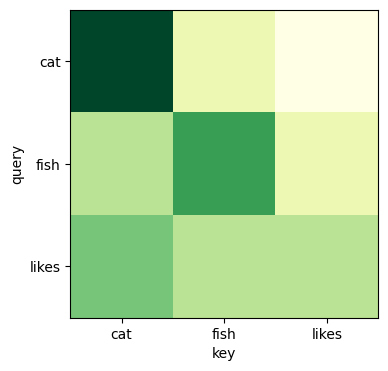

In [4]:
# self-attention 시각화
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# 시각화 함수 만들기
words = ["cat", "fish", "likes"]  #고양이가 생선을 좋아한다
# 가상의 attention 가중치
# 각 해은 해당 단어가 다른 단어들에게 주목하는 정도
attention_weight = np.array([
    [0.7, 0.2, 0.1], #고양이는 자기자신에게 가장 높은 가중치를 부여
    [0.3, 0.5, 0.2],  #생선입장에서의 가중치
    [0.4, 0.3, 0.3] #좋아한다 기준 가중치
])

fig, ax = plt.subplots(figsize=(7,4))
im = ax.imshow(attention_weight, cmap='YlGn')

ax.set_xticks(range(len(words)))
ax.set_yticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_yticklabels(words)

ax.set_xlabel('key')
ax.set_ylabel('query')


In [5]:
# Beam Search : 추론 모델
# 문장을 생성할 때 다음에 나올단어는 수천~수만개가 될수 있는데, 이걸 경우의 수로 따지면..X
# 상위 N개의 후보만 유지, N을 beam size
# beam size =1 매번 가장 좋은 것만 선택(Greedy)
# beam size =4 4개의 가능성을 동시에 탐색

In [ ]:
# beam search가 적용된 알고리즘
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# AutoTokenizer 모델명만 주면 자동으로 갖고옴
# AutoModelForSeq2SeqLM : 요약하는 모델에 사용
# AutoModel: 분류헤더 없는 모델에 사용
# AutoModelForSequenceClassification: 분류모델에 사용
import torch
import time

MODEL_NAME = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

text = """The Amazon rainforest is the world's largest tropical rainforest.
    It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
    The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
    However, deforestation poses a significant threat to this vital ecosystem."""

print('[원본]')
print( text.replace('summarize: ', '') )
inputs = tokenizer(text, return_tensors = 'pt', max_length=512, truncation=True).to(device)
inputs

# 다양한 beam size 실험
beam_sizes = [1,2,4,8]
results = []
for num_beams in beam_sizes:
    print(f'beam size : {num_beams}')
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=num_beams,
        max_length=60,
        min_length=20,
        early_stopping=True,
        no_repeat_ngram_size=3,
        num_return_sequences=1
    )

    elapsed_time = time.time() - start_time
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    results.append((num_beams, summary, elapsed_time))



The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[원본]
The Amazon rainforest is the world's largest tropical rainforest.
    It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries.
    The Amazon is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
    However, deforestation poses a significant threat to this vital ecosystem.
beam size : 1
beam size : 2
beam size : 4
beam size : 8


In [7]:
for num_beams, summary, elapsed_time in results:
    print(f'beam size : {num_beams}')
    print(f'summary : {summary}')
    print(f'측정 시간 : {elapsed_time}')
    print()

beam size : 1
summary : ,, on Earth. The Amazon rainforest is the world's largest tropical rainforest. It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. The amazon rainforest is home to millions of species of plants and animals, many of which are found
측정 시간 : 1.5501704216003418

beam size : 2
summary : . The Amazon rainforest is the world's largest tropical rainforest. It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. The amazon rainforest is home to millions of species of plants and animals, many of which are found nowhere else on Earth.
측정 시간 : 1.836622714996338

beam size : 4
summary : . The Amazon rainforest is the world's largest tropical rainforest. It covers much of northwestern Brazil and extends into Colombia, Peru and other South American countries. The amazon rainforest is home to millions of species of plants and animals, many of which are found nowhere else on E

- beam search : 병렬처리 가능
- Beam = 1(Greedy) -----> 실시간 시스템에 적합
- Beam = 4~5 -----------> 품질과 속도의 균형 (가장 일반적)
- Beam = 8~10 ----------> 최고품질이 필요한 경우 (논문, 공식문서)
- Beam이 크다고 좋지 않음 ==> why? 과도한 탐색을 하기 때문에 (트리모델처럼) 일반화 성능이 떨어짐. 즉 과적합